# ViT Fine-tuning

El presente notebook es el proceso de fine-tuning para [ViT](https://huggingface.co/google/vit-base-patch16-224).

Autores:

Esp. Abraham Rodriguez
Mg. Oksana Bokhonok

In [1]:
pip install datasets transformers


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
#from transformers import MobileViTForImageClassification, MobileViTImageProcessor
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np

/home/rodz/Documents/coding/project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

cuda


# Descargando modelos

In [4]:
dataset = load_dataset('cifar10')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [6]:
train_dataset = load_dataset('cifar10', split='train[:4000]')
test_dataset = load_dataset('cifar10', split='test[:2000]')

In [7]:
id2label = {id:label for id, label in enumerate(train_dataset.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

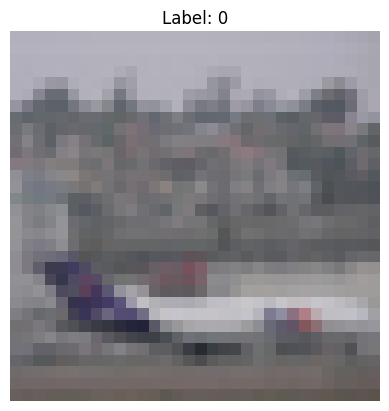

In [9]:
item = train_dataset[0]  # For example, the first image in the dataset

# Display the image
plt.imshow(item['img'])
plt.title(f"Label: {item['label']}")
plt.axis('off')  # Hide the axes for clarity
plt.show()

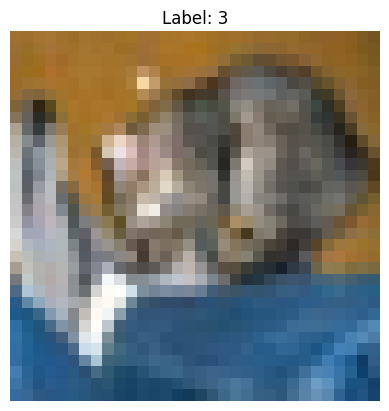

In [10]:
item = test_dataset[0]  # For example, the first image in the dataset

# Display the image
plt.imshow(item['img'])
plt.title(f"Label: {item['label']}")
plt.axis('off')  # Hide the axes for clarity
plt.show()

In [11]:
torch.set_float32_matmul_precision("medium") # optimizacion

In [12]:
def preprocess_function(examples):
    inputs = processor(images=examples['img'], return_tensors="pt", padding=True)
    inputs['labels'] = torch.tensor([0] * len(examples['label']), dtype=torch.float)
    return inputs

In [13]:

def transform(example):
    # Apply feature extractor transforms (resize, normalize, convert to tensor)
    inputs = processor(images=example['img'], return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'].squeeze()  # Remove extra dimension
    example['label'] = example['label']
    return example


train_dataset = train_dataset.map(transform)
test_dataset = test_dataset.map(transform)


In [14]:
train_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'label'])

In [15]:
test_dataset

Dataset({
    features: ['img', 'label', 'pixel_values'],
    num_rows: 2000
})

# Fine-tuning

In [16]:
import os
os.environ["WANDB_DISABLED"] = "true" # no utilizamos weights and biases

In [17]:
training_args = TrainingArguments(
    output_dir="./vit-finetuned-cifar10",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    log_level = 'info',
    fp16 = True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    #compute_metrics=compute_metrics,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using auto half precision backend
The following columns in the training set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4,000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 189
  Number of trainable parameters = 86,567,656
 33%|███▎      | 63/189 [00:34<00:46,  2.71it/s]The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `V

{'eval_loss': 1.1519293785095215, 'eval_runtime': 10.727, 'eval_samples_per_second': 186.445, 'eval_steps_per_second': 2.983, 'epoch': 1.0}


 67%|██████▋   | 126/189 [01:19<00:29,  2.16it/s]The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
                                                 
 67%|██████▋   | 126/189 [01:34<00:29,  2.16it/s]

{'eval_loss': 0.41727039217948914, 'eval_runtime': 15.4048, 'eval_samples_per_second': 129.829, 'eval_steps_per_second': 2.077, 'epoch': 2.0}


100%|██████████| 189/189 [02:13<00:00,  2.20it/s]The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
                                                 
100%|██████████| 189/189 [02:25<00:00,  2.20it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 189/189 [02:25<00:00,  1.30it/s]

{'eval_loss': 0.3490557074546814, 'eval_runtime': 12.3769, 'eval_samples_per_second': 161.591, 'eval_steps_per_second': 2.585, 'epoch': 3.0}
{'train_runtime': 145.7985, 'train_samples_per_second': 82.305, 'train_steps_per_second': 1.296, 'train_loss': 1.7516237289186507, 'epoch': 3.0}


TrainOutput(global_step=189, training_loss=1.7516237289186507, metrics={'train_runtime': 145.7985, 'train_samples_per_second': 82.305, 'train_steps_per_second': 1.296, 'train_loss': 1.7516237289186507, 'epoch': 3.0})

In [18]:
eval_results = trainer.evaluate()
print(eval_results)

The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
100%|██████████| 32/32 [00:10<00:00,  3.15it/s]

{'eval_loss': 0.3490557074546814, 'eval_runtime': 10.8043, 'eval_samples_per_second': 185.112, 'eval_steps_per_second': 2.962, 'epoch': 3.0}


In [19]:
torch.cuda.empty_cache() # limpiamos cache

# Pruebas

In [21]:
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluate the model on test data
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].squeeze(1).float()
        outputs = model(pixel_values=pixel_values.to('cuda'))  # Forward pass
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions.to('cpu') == batch['label']).sum().item()
        total += batch['label'].size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 90.20%


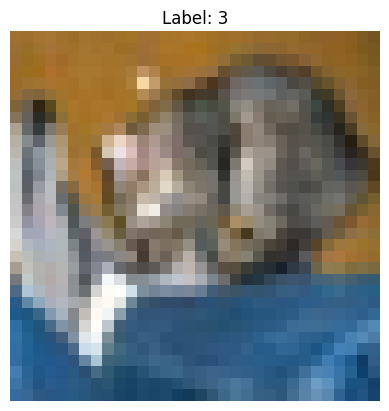

In [22]:
test_item = test_dataset[0]  # For example, the first image in the dataset

# Display the image
plt.imshow(item['img'])
plt.title(f"Label: {item['label']}")
plt.axis('off')  # Hide the axes for clarity
plt.show()

In [47]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [23]:
type(test_item['pixel_values']) 

torch.Tensor

# Resultados

In [24]:
def inference_prediction(image: torch.Tensor, clear_cache = False) -> torch.Tensor:
    with torch.no_grad():
        pixel_values = image.squeeze(1).float().unsqueeze(0)
        outputs = model(pixel_values=pixel_values.to(device)) 
        if clear_cache:
            torch.cuda.empty_cache() # libera memoria de la cache luego de inferencia
        return torch.argmax(outputs.logits, dim=-1)


In [25]:
inference_prediction(test_item['pixel_values']) == test_item["label"]

tensor([True], device='cuda:0')

## Evaluacion con dataset de prueba

In [26]:
outputs = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64
100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


In [32]:
outputs.metrics

{'test_loss': 0.3490557074546814,
 'test_runtime': 11.7338,
 'test_samples_per_second': 170.448,
 'test_steps_per_second': 2.727}

In [29]:
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [31]:
outputs.predictions

array([[ 5.296875  ,  4.0117188 ,  9.3046875 , ...,  0.29907227,
         0.15625   , -0.79345703],
       [ 5.5117188 ,  5.0859375 ,  1.5273438 , ..., -0.38867188,
         0.2902832 , -0.36889648],
       [ 7.2617188 ,  7.25      ,  2.1933594 , ..., -0.47192383,
         0.33618164, -0.4165039 ],
       ...,
       [ 7.1132812 ,  5.6289062 ,  2.2753906 , ...,  0.06378174,
        -0.28393555, -1.0947266 ],
       [ 5.3710938 ,  3.9335938 ,  4.609375  , ..., -0.81152344,
        -0.21191406, -0.42041016],
       [ 4.4335938 ,  4.0742188 ,  6.3242188 , ...,  0.06677246,
        -0.45361328, -0.11956787]], dtype=float32)

In [34]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

In [39]:
np.unique(y_true)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [41]:
y_pred_filtered = np.where(y_pred < len(labels), y_pred, -1)

In [43]:
np.unique(y_pred_filtered)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [40]:
np.unique(y_pred)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 676])

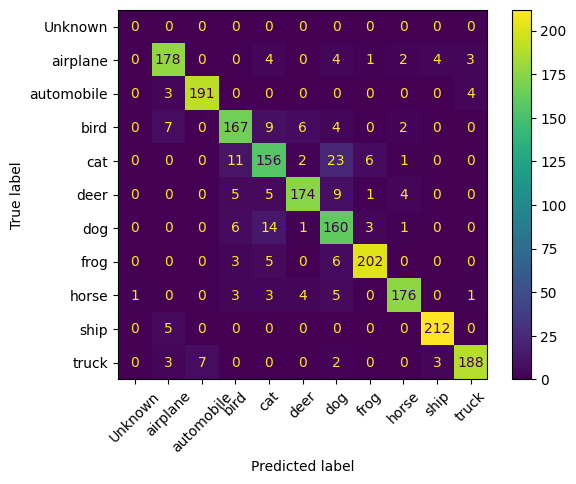

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_dataset.features['label'].names
cm = confusion_matrix(y_true, y_pred_filtered)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unknown"] + labels )
disp.plot(xticks_rotation=45)